In [2]:
import os
import numpy as np

import torch
from torch.utils.data import DataLoader, Dataset

import cv2
import matplotlib.pyplot as plt
from PIL import Image

from skimage.segmentation import slic
from fast_slic import Slic

from mmseg.datasets.transforms import *
from mmseg.datasets import PascalVOCDataset
from mmengine.structures import PixelData


from mmengine.config import Config, DictAction
from mmengine.runner import Runner
import itertools
import time

In [ ]:
def compute_slic(im):
    segments_slic = slic(
        im, n_segments=150, compactness=6, sigma=3.0, start_label=0
    ).astype(np.uint8)
    # im = Image.fromarray(segments_slic)
    
    return segments_slic

def render_in_img(im, superpixels):
    superpixels_ids = np.unique(superpixels)
    mask = (superpixels == superpixel_id).astype(np.uint8)
    # red_mask = np.zeros_like(im)
    # red_mask[:, :, 2] = 255
    color = np.array([0,0,255])
    color = color[None, None, :]

    mask = mask * color
    masked_img = cv2.addWeighted(im, 0.7, mask.astype(np.uint8), 0.3, 0)
    # os.makedirs(os.path.join(out_base_dir, img_name.split(".")[0]), exist_ok=True)
    # cv2.imwrite(os.path.join(out_base_dir, img_name.split(".")[0], str(superpixel_id)+".jpg"), masked_img)
    # import ipdb
    # ipdb.set_trace()
    return masked_img



img = cv2.imread(val_dataset[0]['img_path'])
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# print (type(im))
# im = Image.open(val_dataset[11]['img_path'])
# print (type(im))

sp1 = slic(img, n_segments=150, compactness=6, sigma=3.0, start_label=0).astype(np.uint8)
print (sp.shape)
print (img.shape)
# im_render = render_in_img(im, im_seg)

plt.imshow(sp1)

In [ ]:
sp_dir = '../data/superpixel_img/scikit30'
sps = os.listdir(sp_dir)
sps.sort()

# sp = cv2.imread(os.path.join(sp_dir, sps[0]))
sp_path = os.path.join(sp_dir, sps[0])
# sp = Image.open(sp_path)
sp = cv2.imread(sp_path)
# sp = np.array(sp)
# print (sp.shape)

label2rgb(sp, image_rgb, kind='avg', bg_label=-1)
plt.imshow(sp)

In [ ]:
sp_dir = '../data/superpixel_img/slic150'
sps = os.listdir(sp_dir)
sps.sort()

sp_path = os.path.join(sp_dir, sps[0])
sp = cv2.imread(sp_path) # B G R
# sp = Image.open(sp_path)
# sp = np.array(sp)

img_path = os.path.join('../data/VOCdevkit/VOC2012/JPEGImages', sps[0])
img = cv2.imread(img_path) # B G R

sp_ids = np.unique(sp)
ms = []
for id in sp_ids:
    m = (sp == id)
    ms.append(torch.tensor(m))
ms = torch.stack(ms, dim=0)
ms = ms.permute(0,3,1,2)

color = torch.tensor([[0,0,255], [0,255,0], [255,0,0]]) # R G B
# Red = color[0].reshape(1, 3, 1, 1)
# Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

img_repeated = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).expand_as(ms)
img_re = img_repeated * 0.6 + ms * Blue * 0.4
img_re.shape
sp_ids.shape

In [ ]:
def generate_batch(batch_files, reference_adv_dir, transform):
    batch = []
    gt_labels = []
    tar_labels = []
    imgs = []
    
    for file in batch_files:
        file_split = file.split('_')
        img_name = file_split[0]

        gt_labels.append(file_split[1])
        tar_labels.append(file_split[2].split('.')[0])
        batch.append(torch.from_numpy(np.load(os.path.join(reference_adv_dir, file))))

        img = Image.open(os.path.join('./dataset/images', img_name + '.png'))
        if img.mode != 'RGB':
            img = img.convert('RGB')
        img = transform(img)
        imgs.append(img)
    
    gt_labels = np.array(gt_labels).astype(np.int32)
    tar_labels = np.array(tar_labels).astype(np.int32)
    gt_labels = torch.from_numpy(gt_labels)
    tar_labels = torch.from_numpy(tar_labels)

    return torch.stack(batch), gt_labels, tar_labels, torch.stack(imgs)

reference_advs_files = os.listdir(reference_adv_dir)
num_batches = int(np.ceil(len(reference_advs_files) / batch_size))
reference_advs_files_batch = []
for i in range(num_batches):
    batch = reference_advs_files[i*args.batch_size: min((i+1)*args.batch_size, len(reference_advs_files))]
    reference_advs_files_batch.append(batch)

In [ ]:
val_dataset = PascalVOCDataset(
    data_root = '../data/VOCdevkit/VOC2012',
    data_prefix=dict(
        img_path='JPEGImages', seg_map_path='SegmentationClass'),
    ann_file='ImageSets/Segmentation/val.txt',
)
type(val_dataset)
len(val_dataset)

In [ ]:
def custom_collate_fn(batch):
    """
    Custom collate function to filter out None values.
    """
    # Filter out None values from the batch
    print (batch)
    batch = [{k: v for k, v in item.items() if v is not None} for item in batch]
            
    # Use default_collate to combine the filtered batch
    return torch.utils.data.dataloader.default_collate(batch)

# def custom_collate_fn(batch):
#     """
#     Custom collate function to handle None values in the samples.
#     """
#     # Remove keys with None values from each sample
#     filtered_batch = []
#     for item in batch:
#         filtered_item = {k: v for k, v in item.items() if v is not None}
#         filtered_batch.append(filtered_item)
    
#     return filtered_batch

val_loader = DataLoader(val_dataset, batch_size=2, collate_fn=custom_collate_fn)
next(iter(val_loader))

In [ ]:
classes=['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
        'sofa', 'train', 'tvmonitor']
classes_str = ""
for name in classes:
    classes_str += (name + ", ")
classes_str = classes_str[:-2]
classes_str

In [ ]:
a = [1, 2]
b = [3, 4]
bb = []
bb.append(torch.tensor(a))
bb.append(torch.tensor(b))
c = torch.stack(bb, dim=0)
c.shape

for x, y in zip(a, b):
    print (x, y)

In [ ]:
os.environ['MASTER_ADDR'] = 'localhost'
os.environ['MASTER_PORT'] = '5678'
torch.distributed.init_process_group(
    backend='nccl',
    world_size=int(os.getenv('WORLD_SIZE', '1')),
    rank=int(os.getenv('RANK', '0, 1')),
)
torch.distributed.get_rank()

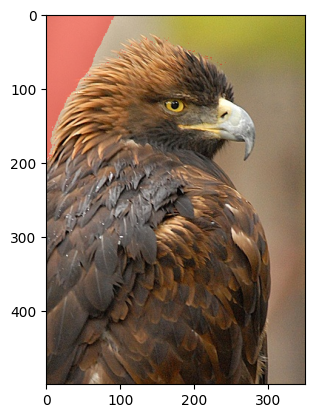

In [180]:
voc_img_base_dir = "../data/VOCdevkit/VOC2012/JPEGImages"
superpixel_base_dir = "../data/superpixel_img/scikit30"
val_img_name_list = os.listdir(superpixel_base_dir)

img_name = val_img_name_list[1]
img = cv2.imread(os.path.join(voc_img_base_dir, img_name.split('.')[0]+".jpg"))
sp = cv2.imread(os.path.join(superpixel_base_dir, img_name))
sp_ids = np.unique(sp)

# Gather per superpixel masks
sp_masks = []
for sp_id in sp_ids:
    mask = (sp == sp_id)
    sp_masks.append(torch.tensor(mask))

sp_masks = torch.stack(sp_masks, dim=0)
sp_masks = sp_masks.permute(0,3,1,2)
img_repeated = torch.tensor(img).unsqueeze(0).permute(0,3,1,2).expand_as(sp_masks)

color = torch.tensor([[0,0,255], [0,255,0], [255,0,0]]) # R G B
Red = color[0].reshape(1, 3, 1, 1)
Green = color[1].reshape(1, 3, 1, 1)
Blue = color[2].reshape(1, 3, 1, 1)

mask_imgs = torch.zeros_like(img_repeated)
remain_imgs = torch.zeros_like(img_repeated)
mask_imgs[sp_masks] = img_repeated[sp_masks]
remain_imgs[sp_masks.logical_not()] = img_repeated[sp_masks.logical_not()]

# superpixels_masks = superpixels_masks * Red



# 图片混合
# rendered_imgs = img_repeated * 0.6 + sp_masks * Red * 0.4
# rendered_imgs = img_repeated * 0.6 + superpixels_masks * Green * 0.4
rendered_imgs = (mask_imgs * 0.6 + sp_masks * Red * 0.4) + remain_imgs
rendered_img = rendered_imgs[0].permute(1, 2, 0).numpy().astype(np.uint8)
rendered_img = cv2.cvtColor(rendered_img, cv2.COLOR_RGB2BGR)
plt.imshow(rendered_img)

(32.9320068359375, 60.511077880859375)


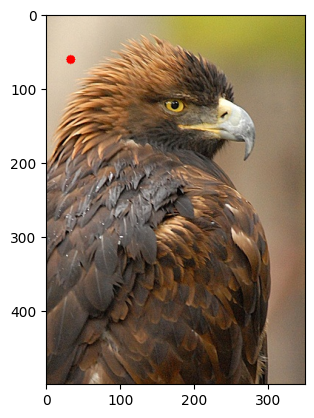

In [186]:
IDs, C, H, W = sp_masks.shape
y_coords = torch.arange(H)[None, None, :, None].expand_as(sp_masks)
x_coords = torch.arange(W)[None, None, None, :].expand_as(sp_masks)

y_weighted = sp_masks * y_coords
x_weighted = sp_masks * x_coords

y_center = y_weighted.sum(dim=(2, 3)) / torch.where(y_weighted != 0, 1, 0).sum(dim=(2, 3))
x_center = x_weighted.sum(dim=(2, 3)) / torch.where(x_weighted != 0, 1, 0).sum(dim=(2, 3))

# print (img_repeated[id].numpy().astype(np.uint8).shape)
print ((x_center[0][0].item(), y_center[0][0].item()))
# for id in range(IDs):
id_img = img_repeated[0].permute(1, 2, 0).numpy().astype(np.uint8)
cv2.circle(id_img, (int(np.round(x_center[0][0].item())), int(np.round(y_center[0][0].item()))), 6, (0, 0, 255), -1)
show_img = cv2.cvtColor(id_img, cv2.COLOR_RGB2BGR)
plt.imshow(show_img)

In [154]:
a = torch.arange(10)
print (a)
a = torch.where(a > 5, 1, 0)
a

tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])


tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 1])

In [ ]:
class RenderedImageDataset(Dataset):
    def __init__(self, rendered_img_dir: str='../data/rendered_img/scikit30'):
        super().__init__()
        # self.tokenizer = tokenizer
        # self.prompt = prompt
        self.rendered_img_dir = rendered_img_dir
        
        self.img_names = os.listdir(rendered_img_dir)
    
    def __getitem__(self, idx):
        id_img_path = os.path.join(self.rendered_img_dir, self.img_names[idx])
        return id_img_path, self.img_names[idx]
    
    def __len__(self):
        return len(self.img_names)


val_dataset = RenderedImageDataset()
val_loader = DataLoader(val_dataset, batch_size=1)
a = next(iter(val_loader))
a

In [ ]:
a = torch.rand(3, 224, 224)
for i in range(a.shape[1]):
    for j in range(a.shape[2]):
        sem_pred[:, i, j] = torch.argmax(torch.bincount(sem_pred_merge[:, i, j]))

In [ ]:
path = '../data/superpixel_img/scikit30/'
img_names = os.listdir(path)
img_names.sort()
img_path = os.path.join(path, img_names[0])
print (img_path)

# img = cv2.imread(img_path)
# print (img.shape)
# img = Image.open(img_path)
# img = np.array(img)
# print (img.shape)
os.path.isdir(path)

In [24]:
classes=['background', 'aeroplane', 'bicycle', 'bird', 'boat',
        'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
        'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep',
        'sofa', 'train', 'tvmonitor']
classes_str = ""
for name in classes:
    classes_str += (name + ", ")
    
print (classes_str)
classes_str = classes_str[:-2]
name2id, id2name = dict(), dict()

for id, class_name in enumerate(classes):
    name2id[class_name] = id
    id2name[id] = class_name
    
name2id
'bird' in name2id.keys()

print (classes_str)

background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor, 
background, aeroplane, bicycle, bird, boat, bottle, bus, car, cat, chair, cow, diningtable, dog, horse, motorbike, person, pottedplant, sheep, sofa, train, tvmonitor


In [ ]:
import random

# 文件路径
input_file = '/remote-home/zhangjiacheng/RVP/data/VOCdevkit/VOC2012/ImageSets/Segmentation/val.txt'
output_file = '/remote-home/zhangjiacheng/RVP/data/VOCdevkit/VOC2012/ImageSets/Segmentation/val100.txt'

# 读取所有行
with open(input_file, 'r') as f:
    lines = f.readlines()

# 随机抽取100行
selected_lines = random.sample(lines, 100)

# 写入到新的txt文件中
with open(output_file, 'w') as f:
    f.writelines(selected_lines)


In [12]:
cfg = Config.fromfile('../mmsegmentation/my_configs/pascal_voc12_base.py')
cfg.launcher = 'none'
cfg.work_dir = os.path.join('./work_dirs',
                            os.path.splitext(os.path.basename('../mmsegmentation/my_configs/pascal_voc12_base.py'))[0])
cfg.load_from = None

# build the runner from config
runner = Runner.from_cfg(cfg)
val_dataloader = runner.val_dataloader
evaluator = runner.val_evaluator

11/02 04:33:15 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.18 (main, Sep 11 2023, 13:41:44) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 406929822
    GPU 0,1,2,3,4,5,6,7: Tesla V100S-PCIE-32GB
    CUDA_HOME: /home/jy/apps/cuda-11.7
    NVCC: Cuda compilation tools, release 11.7, V11.7.64
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch

/home/jy/mm/RVP/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/jy/mm/RVP/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/home/jy/mm/RVP/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:249: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


11/02 04:33:24 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
11/02 04:33:24 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

[<SegDataSample(
 
     META INFORMATION
     seg_map_path: '/home/jy/mm/RVP/data/VOCdevkit/VOC2012/SegmentationClass/2009_001332.png'
     ori_shape: (333, 500)
     img_path: '/home/jy/mm/RVP/data/VOCdevkit/VOC2012/JPEGImages/2009_001332.jpg'
     img_shape: (333, 500)
     reduce_zero_label: False
 
     DATA FIELDS
     gt_sem_seg: <PixelData(
         
             META INFORMATION
         
             DATA FIELDS
             data: tensor([[[0, 0, 0,  ..., 0, 0, 0],
                          [0, 0, 0,  ..., 0, 0, 0],
                          [0, 0, 0,  ..., 0, 0, 0],
                          ...,
                          [0, 0, 0,  ..., 0, 0, 0],
                          [0, 0, 0,  ..., 0, 0, 0],
                          [0, 0, 0,  ..., 0, 0, 0]]])
         ) at 0x7f828b878640>
 ) at 0x7f828b878970>]

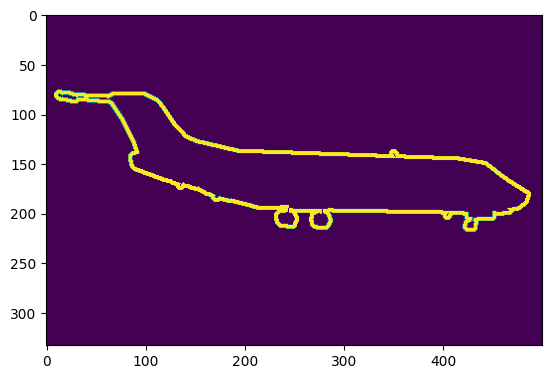

In [18]:
for data in val_dataloader:
    # print (data)
    break

img = data["inputs"][0].permute(1,2,0).numpy()
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
gt_seg = data['data_samples'][0].gt_sem_seg.data.permute(1, 2, 0).numpy()
plt.imshow(gt_seg)

data['data_samples']

In [13]:
runner = Runner.from_cfg(cfg)
val_dataloader = runner.val_dataloader
evaluator = runner.val_evaluator

11/02 04:33:24 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.18 (main, Sep 11 2023, 13:41:44) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 565145743
    GPU 0,1,2,3,4,5,6,7: Tesla V100S-PCIE-32GB
    CUDA_HOME: /home/jy/apps/cuda-11.7
    NVCC: Cuda compilation tools, release 11.7, V11.7.64
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.13.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.6.0 (Git Hash 52b5f107dd9cf10910aaa19cb47f3abf9b349815)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch

/home/jy/anaconda3/envs/mm/lib/python3.9/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(


11/02 04:33:26 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
11/02 04:33:26 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                